In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone

In [2]:
BASE_PATH = "/kaggle/input/the-oxford-iii-t-pet-dataset/" 
IMAGES_PATH = os.path.join(BASE_PATH, "images/images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations/annotations")

IMG_SIZE = (128, 128)

In [3]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data_complete(folder_path, img_size=(128, 128)):
    X = []
    y_especie = [] # 0: Gato, 1: Cachorro
    y_raca = []
    
    print("Carregando imagens e extraindo raças...")
    
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                
                if filename[0].islower():
                    label = 1 
                else:
                    label = 0 
                
                breed = filename.rsplit('_', 1)[0]
                
                X.append(img.flatten())
                y_especie.append(label)
                y_raca.append(breed)
                
            except Exception as e:
                pass

    return np.array(X), np.array(y_especie), np.array(y_raca)

In [4]:
X, y, y_breed = load_data_complete(IMAGES_PATH, IMG_SIZE)

Carregando imagens e extraindo raças...


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np


print(f"Total de imagens: {len(X)}")
print(f"Exemplos de raças no dataset: {np.unique(y_breed)[:5]}")

le = LabelEncoder()
y_encoded = le.fit_transform(y_breed)

class_names = le.classes_
print(f"Total de Classes (Raças): {len(class_names)}")

Total de imagens: 7390
Exemplos de raças no dataset: ['Abyssinian' 'Bengal' 'Birman' 'Bombay' 'British_Shorthair']
Total de Classes (Raças): 37


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (5912, 49152), Teste: (1478, 49152)


In [7]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt

# --- 4. FUNÇÕES DE EXTRAÇÃO (HOG e LBP) ---

def extract_hog_features(X, img_size):
    features_list = []
    print(f"   > Extraindo HOG de {len(X)} imagens...")
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        # Parâmetros otimizados
        f = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features_list.append(f)
    return np.array(features_list)

def extract_lbp_features(X, img_size, P=8, R=1):
    features_list = []
    print(f"   > Extraindo LBP de {len(X)} imagens...")
    n_bins = P + 2 
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        # Histograma normalizado
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        features_list.append(hist)
    return np.array(features_list)

In [ ]:
print("1. Extraindo Features do TREINO (HOG + LBP)...")
X_train_hog = extract_hog_features(X_train, IMG_SIZE)
X_train_lbp = extract_lbp_features(X_train, IMG_SIZE)
X_train_final = np.hstack((X_train_hog, X_train_lbp))

print("2. Extraindo Features do TESTE (HOG + LBP)...")
X_test_hog = extract_hog_features(X_test, IMG_SIZE)
X_test_lbp = extract_lbp_features(X_test, IMG_SIZE)
X_test_final = np.hstack((X_test_hog, X_test_lbp))

print(f"Shape Final das Features: {X_train_final.shape}")

1. Extraindo Features do TREINO (HOG + LBP)...
   > Extraindo HOG de 5912 imagens...
   > Extraindo LBP de 5912 imagens...
2. Extraindo Features do TESTE (HOG + LBP)...
   > Extraindo HOG de 1478 imagens...
   > Extraindo LBP de 1478 imagens...
Shape Final das Features: (5912, 8110)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

print("3. Treinando Random Forest para 37 Raças...")

rf_all_breeds = RandomForestClassifier(
    n_estimators=500, 
    random_state=42, 
    n_jobs=-1
)

rf_all_breeds.fit(X_train_final, y_train)
print("Modelo treinado com sucesso!")

3. Treinando Random Forest para 37 Raças...
Modelo treinado com sucesso!


=== RESULTADO GERAL (37 RAÇAS) ===
Acurácia Global: 2.17%
(Note que o chute aleatório seria apenas 2.7%)

Relatório por Raça:
                            precision    recall  f1-score   support

                Abyssinian       0.00      0.00      0.00        40
                    Bengal       0.00      0.00      0.00        40
                    Birman       0.00      0.00      0.00        40
                    Bombay       0.00      0.00      0.00        40
         British_Shorthair       0.00      0.00      0.00        40
              Egyptian_Mau       0.00      0.00      0.00        40
                Maine_Coon       0.00      0.00      0.00        40
                   Persian       0.03      0.47      0.06        40
                   Ragdoll       0.00      0.00      0.00        40
              Russian_Blue       0.00      0.00      0.00        40
                   Siamese       0.00      0.00      0.00        40
                    Sphynx       0.00      0.00      0.00

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


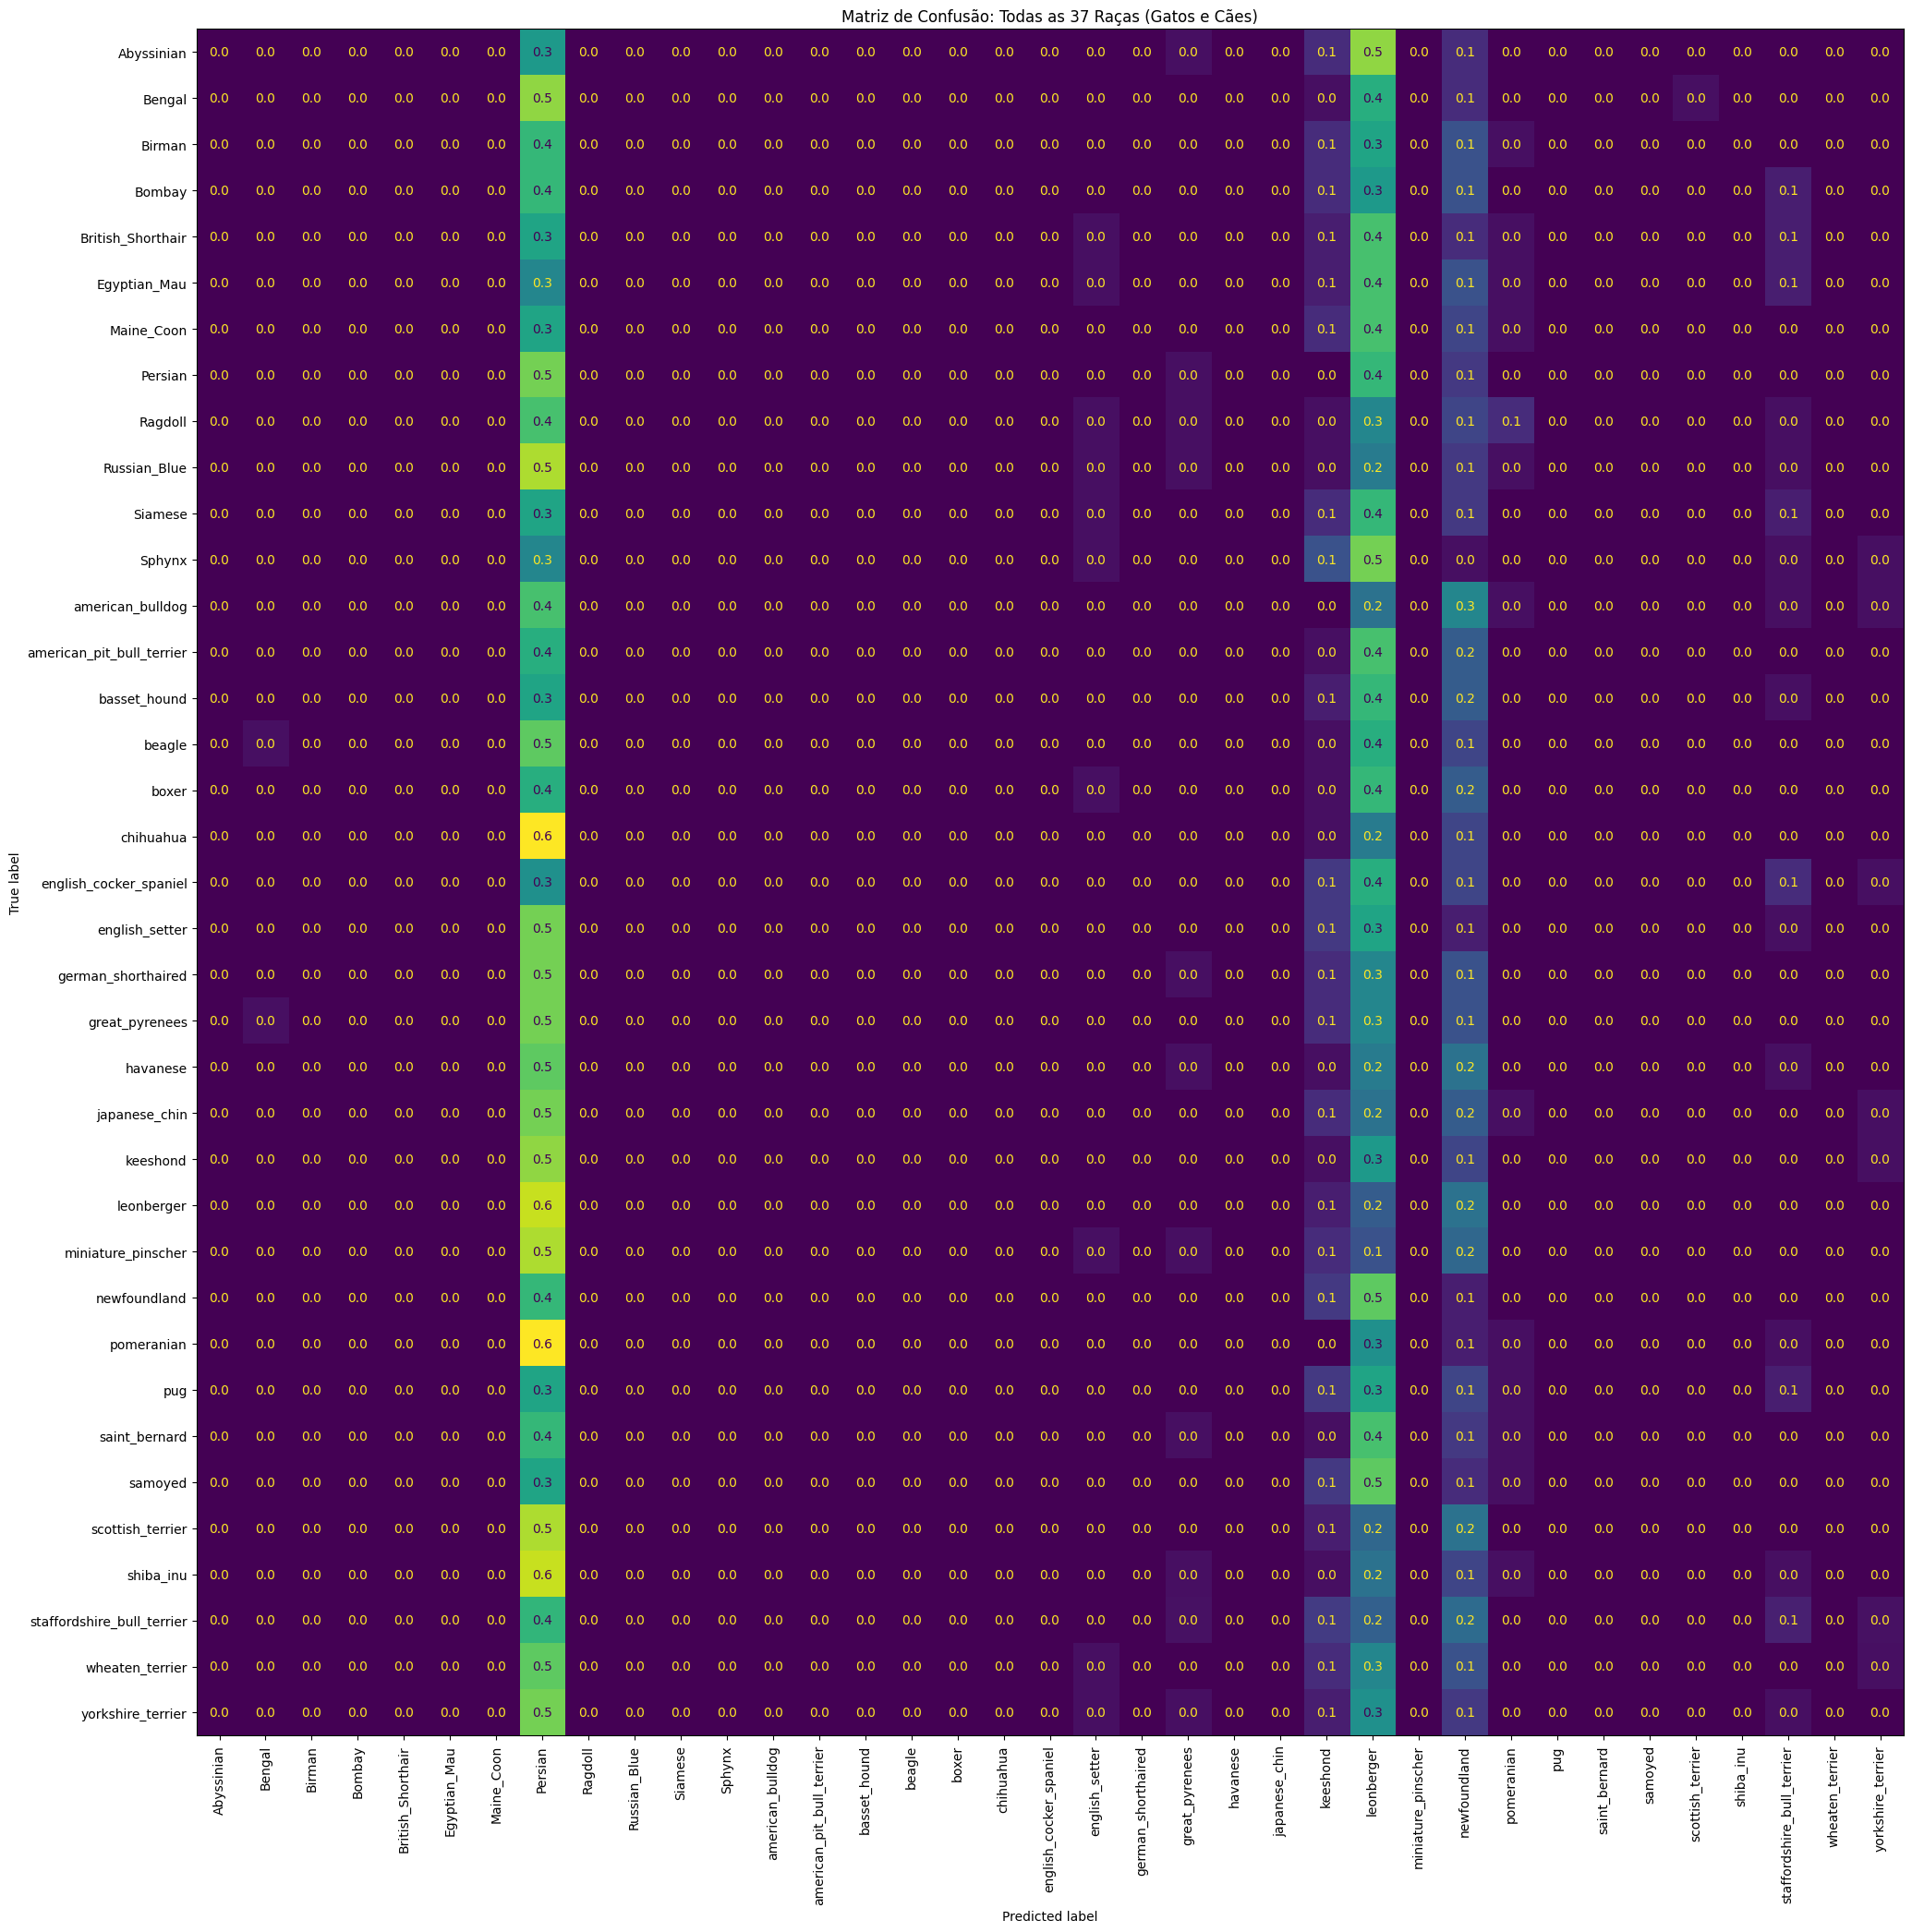

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

y_pred_all = rf_all_breeds.predict(X_test_final)

acc = accuracy_score(y_test, y_pred_all)
print(f"=== RESULTADO GERAL (37 RAÇAS) ===")
print(f"Acurácia Global: {acc:.2%}")
print("(Note que o chute aleatório seria apenas 2.7%)")

print("\nRelatório por Raça:")
print(classification_report(y_test, y_pred_all, target_names=class_names))

fig, ax = plt.subplots(figsize=(24, 24))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_all, 
    normalize="true",      
    display_labels=class_names, 
    cmap="viridis",        
    xticks_rotation='vertical',
    values_format=".1f",  
    ax=ax,
    colorbar=False
)

plt.title("Matriz de Confusão: Todas as 37 Raças (Gatos e Cães)")
plt.show()